In [2]:
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import HumanMessage

import os
from dotenv import load_dotenv
os.environ["OPENAI_API_TYPE"] 
os.environ["OPENAI_API_VERSION"] 
os.environ["OPENAI_API_BASE"] 
os.environ["OPENAI_API_KEY"] 

model = AzureChatOpenAI(
    deployment_name='gpt-35-turbo',
    openai_api_type="azure",
    temperature = 0
)

model(
    [
        HumanMessage(
            content="Translate this sentence from English to French. I love programming."
        )
    ]
)

AIMessage(content="J'aime programmer.", additional_kwargs={}, example=False)

In [3]:
import os
from dotenv import load_dotenv
from langchain.agents.agent_toolkits import AzureCognitiveServicesToolkit

load_dotenv()

azure_cogs_key = os.environ["AZURE_COGS_KEY"]
azure_cogs_endpoint = os.environ["AZURE_COGS_ENDPOINT"]
azure_cogs_region = os.environ["AZURE_COGS_REGION"]

toolkit = AzureCognitiveServicesToolkit().get_tools()
[(tool.name, tool.description) for tool in toolkit]



[('azure_cognitive_services_form_recognizer',
  'A wrapper around Azure Cognitive Services Form Recognizer. Useful for when you need to extract text, tables, and key-value pairs from documents. Input should be a url to a document.'),
 ('azure_cognitive_services_speech2text',
  'A wrapper around Azure Cognitive Services Speech2Text. Useful for when you need to transcribe audio to text. Input should be a url to an audio file.'),
 ('azure_cognitive_services_text2speech',
  'A wrapper around Azure Cognitive Services Text2Speech. Useful for when you need to convert text to speech. '),
 ('azure_cognitive_services_image_analysis',
  'A wrapper around Azure Cognitive Services Image Analysis. Useful for when you need to analyze images. Input should be a url to an image.')]

In [4]:
tools = [toolkit[3]]
tools

[AzureCogsImageAnalysisTool(name='azure_cognitive_services_image_analysis', description='A wrapper around Azure Cognitive Services Image Analysis. Useful for when you need to analyze images. Input should be a url to an image.', args_schema=None, return_direct=False, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, handle_tool_error=False, azure_cogs_key='', azure_cogs_endpoint='', vision_service=<azure.ai.vision.VisionServiceOptions object at 0x000001E8DFE19ED0>, analysis_options=<azure.ai.vision.ImageAnalysisOptions object at 0x000001E8DFEB9F30>)]

In [5]:
from langchain.agents import initialize_agent
from langchain.agents import AgentType

agent = initialize_agent(
    tools=tools,
    llm=model,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    output_key='img_desc'
)

In [10]:
query = """
Given the following picture, generate the html code for a newsletter webpage with the same component as in the picture.
"""

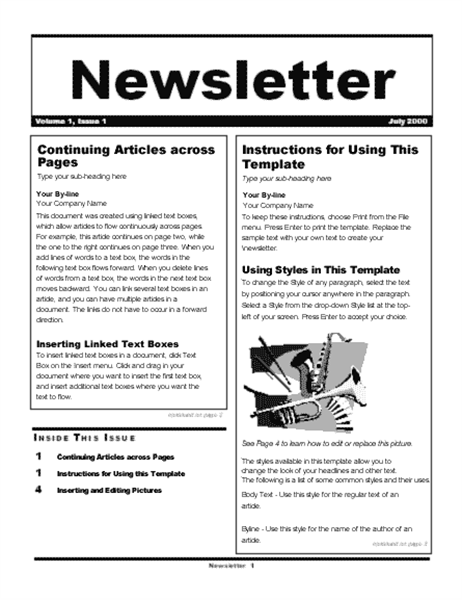

In [59]:
from IPython.display import Image, display
display(Image('https://omextemplates.content.office.net/support/templates/en-us/lt06206295.png', width=600, unconfined=True))

In [6]:
result = agent("Describe the following picture:" "https://omextemplates.content.office.net/support/templates/en-us/lt06206295.png")



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://omextemplates.content.office.net/support/templates/en-us/lt06206295.png"
  }
}
```

Observation: Caption: a newsletter with text and images
Tags: text, newspaper, publication, screenshot, printing, design
Text: Newsletter, July 2000, Continuing Articles across, Instructions for Using This, Pages, Template, Type your sub heading here, Type your sub heading have, Your Bydine, Your Company Name, Your By-line, Your Company Name, This document was created using Inked text boxes,, which allow artides to flow continuoudy across pages, To keep these instructions, choose Print from the File, meraa Press Enter to paint the template. Reple the, For example, this artide continues on page two, while, the one to the right continues on page three. When you, sample test with your own test to create your, Inewsletter., add lines of words to a text box, t

In [7]:
print(result['output'])

The picture is a screenshot of a newsletter template from July 2000. It includes instructions for using the template, information on inserting and editing pictures, and multiple articles with text boxes that allow articles to flow continuously across pages.


In [9]:
agent("Describe in painstaking details the following picture:" "https://i.pinimg.com/originals/a3/ca/d4/a3cad42b84471bf4ffb43cd42e5b8c82.png")



> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://i.pinimg.com/originals/a3/ca/d4/a3cad42b84471bf4ffb43cd42e5b8c82.png"
  }
}
```


Observation: Caption: a screen shot of a computer mouse and glasses
Objects: computer mouse
Tags: text, screenshot, table, design, indoor
Text: POSTED 22.DECEMBER 2014., #DESIGN, How to create beautiful, typography, Typography is the visual component of the written word. It, is for the benefit of the reader , not the writer., READ ARTICLE
Thought:Based on the image analysis, the picture is a screenshot of a computer mouse and glasses. The image also contains text, including a caption that says "POSTED 22.DECEMBER 2014., #DESIGN, How to create beautiful typography. Typography is the visual component of the written word. It is for the benefit of the reader, not the writer. READ ARTICLE." The tags associated with the image include text, screenshot, table, desi

{'input': 'Describe in painstaking details the following picture:https://i.pinimg.com/originals/a3/ca/d4/a3cad42b84471bf4ffb43cd42e5b8c82.png',
 'output': 'The picture is a screenshot of a computer mouse and glasses. It contains text with a caption that talks about creating beautiful typography for the benefit of the reader. The image tags include text, screenshot, table, design, and indoor.'}

In [11]:
from langchain.chains import SimpleSequentialChain, LLMChain
from langchain.prompts import PromptTemplate

codex = """You are an expert front-end developer. You develop beautiful webpages in HTML given an image description:

{img_desc}

Generate the HTML code with the right indentation.

===>Example start

<div class="container">
    <img src="img.jpg" alt="A beautiful image">
    <p>This is a beautiful image</p>
</div>

<===Example end

Begin!

"""
codex_template = PromptTemplate(input_variables=["img_desc"], template=codex)
codex_chain = LLMChain(llm=model, prompt=codex_template, output_key="story")

In [12]:
overall_chain = SimpleSequentialChain(chains=[agent, codex_chain], verbose = True)

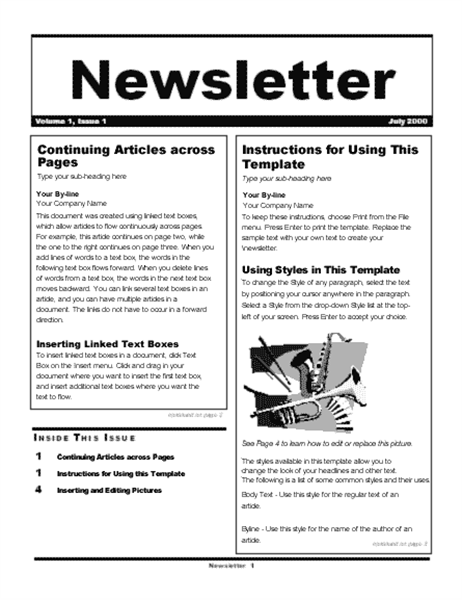

In [60]:
from IPython.display import Image, display
display(Image('https://omextemplates.content.office.net/support/templates/en-us/lt06206295.png', width=600, unconfined=True))

In [28]:
result = overall_chain.run("Give a description in painstaking details of the following webpage frontend, so that I can replicate it with code:" "https://omextemplates.content.office.net/support/templates/en-us/lt06206295.png")



> Entering new SimpleSequentialChain chain...


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://omextemplates.content.office.net/support/templates/en-us/lt06206295.png"
  }
}
```


Observation: Caption: a newsletter with text and images
Tags: text, newspaper, publication, screenshot, printing, design
Text: Newsletter, July 2000, Continuing Articles across, Instructions for Using This, Pages, Template, Type your sub heading here, Type your sub heading have, Your Bydine, Your Company Name, Your By-line, Your Company Name, This document was created using Inked text boxes,, which allow artides to flow continuoudy across pages, To keep these instructions, choose Print from the File, meraa Press Enter to paint the template. Reple the, For example, this artide continues on page two, while, the one to the right continues on page three. When you, sample test with your own test to create your, 

In [29]:
print(result)

<!DOCTYPE html>
<html>
<head>
	<title>July 2000 Newsletter</title>
	<style>
		.container {
			max-width: 800px;
			margin: 0 auto;
			padding: 20px;
			background-color: #f2f2f2;
			font-family: Arial, sans-serif;
		}
		h1 {
			font-size: 36px;
			font-weight: bold;
			margin-bottom: 20px;
		}
		h2 {
			font-size: 24px;
			font-weight: bold;
			margin-top: 40px;
			margin-bottom: 20px;
		}
		p {
			font-size: 16px;
			line-height: 1.5;
			margin-bottom: 20px;
		}
		.text-box {
			display: inline-block;
			width: 45%;
			vertical-align: top;
			margin-right: 5%;
		}
		.image-box {
			display: inline-block;
			width: 45%;
			vertical-align: top;
			margin-left: 5%;
		}
		.image-box img {
			max-width: 100%;
			height: auto;
			margin-bottom: 20px;
		}
	</style>
</head>
<body>
	<div class="container">
		<h1>July 2000 Newsletter</h1>
		<div class="text-box">
			<h2>Article Title</h2>
			<p>Lorem ipsum dolor sit amet, consectetur adipiscing elit. Sed euismod, velit vel bibendum bibendum, nu

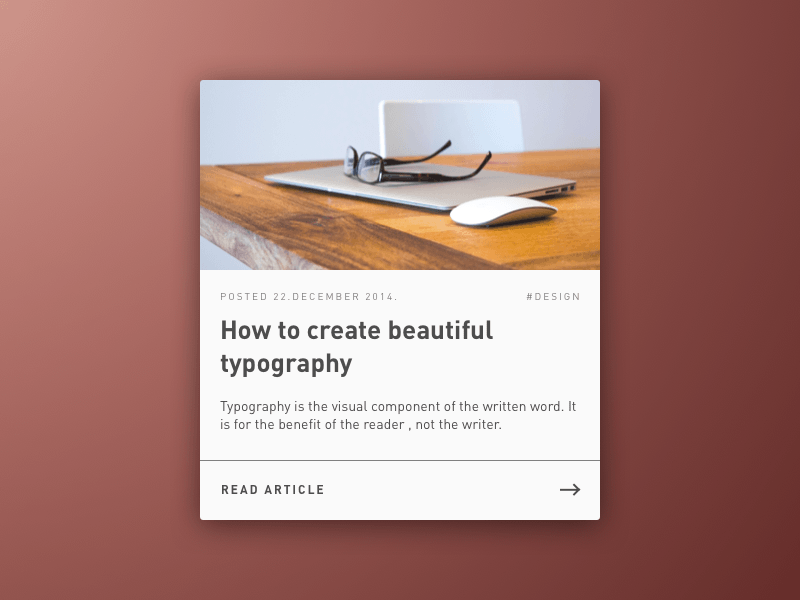

In [62]:
from IPython.display import Image, display
display(Image('https://i.pinimg.com/originals/a3/ca/d4/a3cad42b84471bf4ffb43cd42e5b8c82.png', width=600, unconfined=True))

In [57]:
result = overall_chain.run("Give a detailed description of the following webpage frontend (position of widgets, dimensions, etc), so that I can replicate it with code:" "https://i.pinimg.com/originals/a3/ca/d4/a3cad42b84471bf4ffb43cd42e5b8c82.png")
print(result)



> Entering new SimpleSequentialChain chain...


> Entering new AgentExecutor chain...


Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://i.pinimg.com/originals/a3/ca/d4/a3cad42b84471bf4ffb43cd42e5b8c82.png"
  }
}
```


Observation: Caption: a screen shot of a computer mouse and glasses
Objects: computer mouse
Tags: text, screenshot, table, design, indoor
Text: POSTED 22.DECEMBER 2014., #DESIGN, How to create beautiful, typography, Typography is the visual component of the written word. It, is for the benefit of the reader , not the writer., READ ARTICLE
Thought:I'm sorry, but the previous response was incorrect. The image analysis tool was not able to accurately describe the webpage layout. However, I can provide you with some general guidelines on how to replicate the webpage layout:

The webpage appears to have a white background with a black header at the top. The header contains a logo on the left and a navigation menu on the right. Below the header is a large image of a computer mouse and glasses. To the r

In [58]:
print(result)

<!DOCTYPE html>
<html>
<head>
	<title>Webpage Layout</title>
	<style>
		body {
			background-color: #fff;
			margin: 0;
			padding: 0;
			font-family: Arial, sans-serif;
		}
		header {
			background-color: #000;
			color: #fff;
			display: flex;
			align-items: center;
			padding: 10px;
		}
		.logo {
			margin-right: auto;
		}
		nav {
			margin-left: auto;
		}
		nav ul {
			list-style: none;
			margin: 0;
			padding: 0;
			display: flex;
		}
		nav li {
			margin-left: 20px;
		}
		nav a {
			color: #fff;
			text-decoration: none;
			font-weight: bold;
			font-size: 16px;
		}
		nav a:hover {
			color: #ccc;
		}
		.container {
			max-width: 1200px;
			margin: 0 auto;
			padding: 20px;
		}
		.image {
			float: left;
			margin-right: 20px;
		}
		table {
			border-collapse: collapse;
			margin-top: 20px;
			width: 100%;
		}
		td {
			padding: 10px;
			border: 1px solid #ccc;
		}
		.read-article {
			background-color: #000;
			color: #fff;
			padding: 10px 20px;
			border: none;
			border-rad

In [13]:
result = overall_chain.run("Describe in painstaking details the following webpage frontend (position of widgets, dimensions, etc), so that I can replicate it with code:" "https://i.pinimg.com/originals/a3/ca/d4/a3cad42b84471bf4ffb43cd42e5b8c82.png")
print(result)



> Entering new SimpleSequentialChain chain...


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://i.pinimg.com/originals/a3/ca/d4/a3cad42b84471bf4ffb43cd42e5b8c82.png"
  }
}
```


Observation: Caption: a screen shot of a computer mouse and glasses
Objects: computer mouse
Tags: text, screenshot, table, design, indoor
Text: POSTED 22.DECEMBER 2014., #DESIGN, How to create beautiful, typography, Typography is the visual component of the written word. It, is for the benefit of the reader , not the writer., READ ARTICLE
Thought:To replicate the webpage frontend, you will need to create a layout with the following widgets and dimensions:

1. A header with the text "POSTED 22.DECEMBER 2014." on the left side of the page.
2. A button with the text "#DESIGN" on the right side of the header.
3. A screenshot of a computer mouse and glasses in the center of the page.
4. A table with two columns and

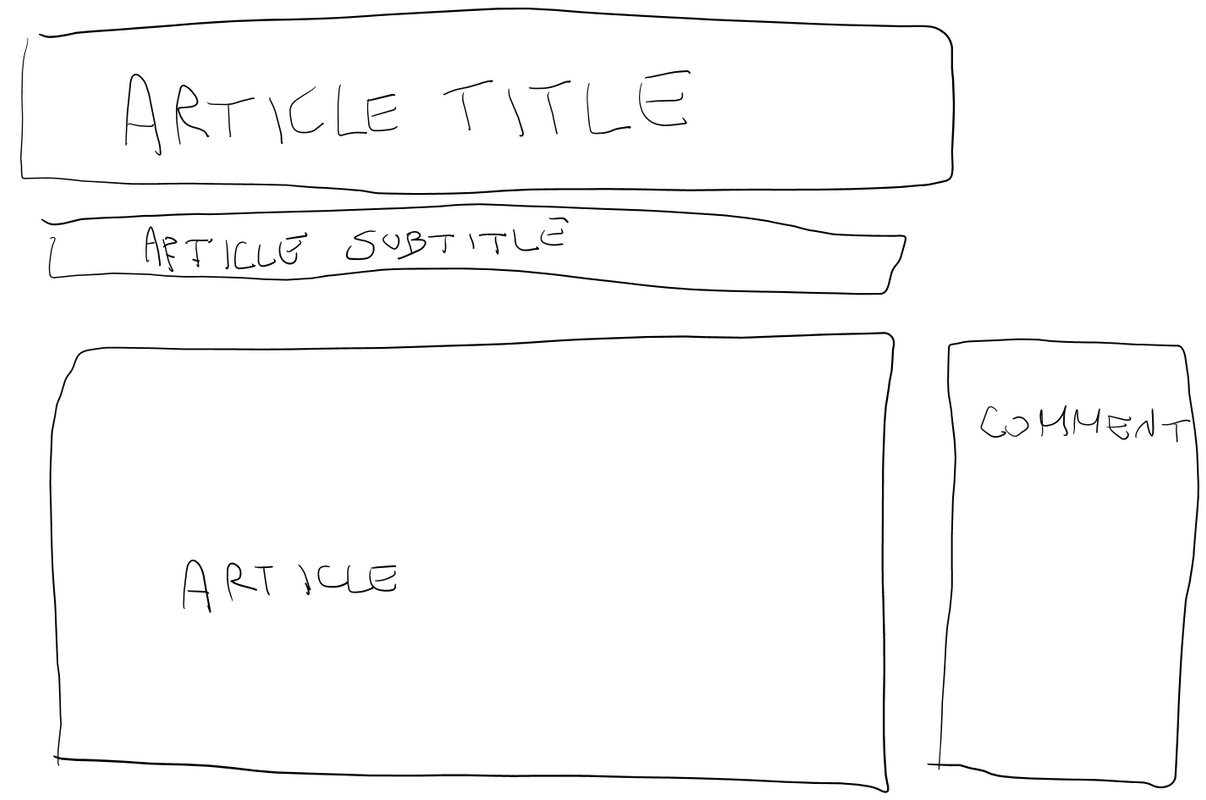

In [38]:
display(Image("https://i.postimg.cc/x8s8LnWf/Screenshot-2023-09-08-164723.png", width=600, unconfined=True))

In [37]:
result = overall_chain("Describe in painstaking details the following picture, so that I can create a similar webpage with code:" "https://i.postimg.cc/x8s8LnWf/Screenshot-2023-09-08-164723.png")
print(result)



> Entering new SimpleSequentialChain chain...


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://i.postimg.cc/x8s8LnWf/Screenshot-2023-09-08-164723.png"
  }
}
```


Observation: Caption: a wireframe of a website
Tags: text, handwriting, sketch, drawing, diagram, font
Text: ARTICLE TITLE, ARTICLE SUBTITLE, COMMENT, ARTICLE
Thought:To create a similar webpage with code, you would need to replicate the wireframe shown in the image. The wireframe is a sketch or diagram of a website, showing the layout and placement of various elements. 

The wireframe consists of four main sections: ARTICLE TITLE, ARTICLE SUBTITLE, COMMENT, and ARTICLE. Each section is labeled with a heading in capital letters. 

The ARTICLE TITLE section is located at the top of the wireframe and is centered on the page. The text is written in a bold, sans-serif font. 

The ARTICLE SUBTITLE section is located directly bel

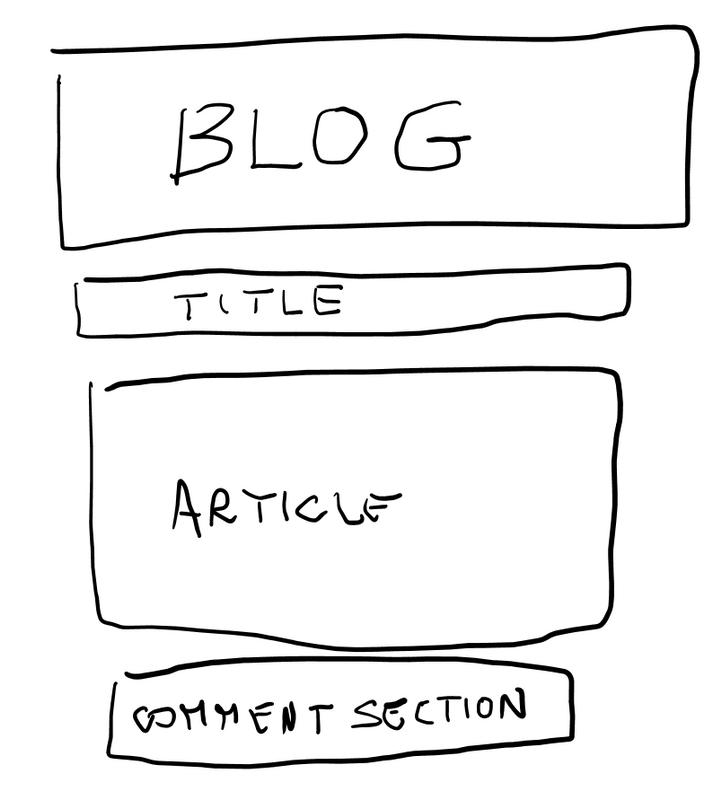

In [39]:
display(Image("https://i.postimg.cc/SsktMh6t/Screenshot-2023-09-08-165826.png", width=600, unconfined=True))

In [40]:
result = overall_chain("Describe in painstaking details the following picture, so that I can create a similar webpage with code:" "https://i.postimg.cc/SsktMh6t/Screenshot-2023-09-08-165826.png")
print(result)



> Entering new SimpleSequentialChain chain...


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "azure_cognitive_services_image_analysis",
  "action_input": {
    "query": "https://i.postimg.cc/SsktMh6t/Screenshot-2023-09-08-165826.png"
  }
}
```


Observation: Caption: a black and white drawing of a website
Tags: text, sketch, drawing, white, font, line art, illustration
Text: BLOG, TITLE, ARTICLE, COMMENT SECTION
Thought:To describe the picture in detail, it is a black and white drawing of a website. The website has a header with the word "BLOG" written in a bold font. Below the header is a section for the title of the article, which is written in a smaller font. The main body of the website has a section for the article content, which is separated by a line art illustration. At the bottom of the website, there is a comment section with a text box for users to input their comments.

> Finished chain.
To describe the picture in detail, it is a black and white drawing